# Teszt adatok

Két normál eloszlású populació keveréke. 

In [1]:
import numpy as np

# mintavetelek szama
n = 1000
# how many come from the first population
p = 0.6

# mintak az elso populaciobol
elso_populacio = np.random.normal(19, 3, int(n*p))
# mintak a masodik populaciobol
masodik_populacio = np.random.normal(13, 4.5, int(n*(1-p)))

# osszekeverjuk a megfigyeleseket
observation = np.concatenate((elso_populacio, masodik_populacio))
indexes = [ i for i in range(len(observation))]
np.random.shuffle( indexes ) 
observation = observation[indexes]

In [2]:
ns = [ i+1 for i in range(len(observation))]
# megfigyelt momentumok
mu1_vesszo = np.divide(np.cumsum(observation), ns)[-1]
mu2_vesszo = np.divide(np.cumsum( [ o**2 for o in observation ] ), ns)[-1]
mu3_vesszo = np.divide(np.cumsum( [ o**3 for o in observation ] ), ns)[-1]
mu4_vesszo = np.divide(np.cumsum( [ o**4 for o in observation ] ), ns)[-1]
mu5_vesszo = np.divide(np.cumsum( [ o**5 for o in observation ] ), ns)[-1]
mu6_vesszo = np.divide(np.cumsum( [ o**6 for o in observation ] ), ns)[-1]

# Megoldas a momentumok modszerével



In [3]:
q = mu1_vesszo
mu1 = mu1_vesszo-q
mu2 = mu2_vesszo-2*q*mu1_vesszo+q**2
mu3 = mu3_vesszo-3*q*mu2_vesszo+3*q**2*mu1_vesszo-q**3
mu4 = mu4_vesszo-4*q*mu3_vesszo+6*q**2*mu2_vesszo-4*q**3*mu1_vesszo+q**4
mu5 = mu5_vesszo-5*q*mu4_vesszo+10*q**2*mu3_vesszo-10*q**3*mu2_vesszo + 5 *q**4*mu1_vesszo-q**5
lambda4 = 9*mu2**2-3*mu4
lambda5 = 30*mu2*mu3-3*mu5

In [4]:
a2 = -28/24*lambda4
a3 = 36/24*mu3**2
a4 = -mu3*lambda5-10/24*lambda4**2
a5 = -(148*mu3**2*lambda4+2*lambda5**2)/24
a6 = (288*mu3**4-12*lambda4*lambda5*mu3-lambda4**3)/24
a7 = (24*mu3**3*lambda5-7*mu3**2*lambda4**2)/24
a8 = (32*mu3**4*lambda4)/24
a9 = -(24*mu3**6)/24

In [5]:
from sympy import symbols, Eq, solve
x = symbols('x')
eq = Eq(x**9 + a2*x**7 + a3*x**6 + a4*x**5 + a5*x**4 + a6*x**3 + a7*x**2 + a8*x + a9, 0 )
sol = solve(eq)
sol = [ complex(s) for s in sol  ]
p2 = np.array([ float(s.real) for s in sol if s.imag == 0j and s.real >= -10 and s.real <= 10 ])

In [6]:
p3 = np.divide( 
         np.subtract(
             np.subtract(
                 np.subtract( 
                     2*mu3**3, 
                     2*mu3*lambda4*p2
                 ), 
                 lambda5*np.power(p2, 2)), 
             8*mu3*np.power(p2, 3) 
         ), 
         np.add(
             np.subtract(
                 4*mu3**2, 
                 lambda4*p2
             ) ,
             2*np.power(p2, 3)
         ) 
     )
p1 = np.divide(p3, p2)

In [7]:
from math import isinf, isnan
models = {}
for idx in range(len(p2)):
    # gammak megoldasa a jól ismert masodfokú megoldóképlettel
    gamma = np.array( [ (p1[idx]-np.sqrt(p1[idx]**2-4*p2[idx]))/2, (p1[idx]+np.sqrt(p1[idx]**2-4*p2[idx]))/2 ] ) 
    # a gammak dobása amiknek nincs valós megoldása
    if isnan(gamma[0]) or isnan(gamma[1]):
        continue
    mu = mu1_vesszo+gamma
    z = np.array([ -gamma[1]/(gamma[0]-gamma[1]), gamma[0]/(gamma[0]-gamma[1]) ])
    if isinf(z[0]):
        continue

    sigma2 = np.array( [
        mu2 - mu3/(3*gamma[1]) - p1[idx]*gamma[0]/3 + p2[idx],
        mu2 - mu3/(3*gamma[0]) - p1[idx]*gamma[1]/3 + p2[idx]
    ])
    
    
    # 6. momentum
    check = float(np.sum(np.multiply(z, ( 15*sigma2**3+45*mu**2*sigma2**2+15*mu**4*sigma2+mu**6 )  )))
    
    models[idx] = { '6th moment loss': np.abs(mu6_vesszo-check), 'mean': mu, 'std': np.sqrt(sigma2), 'p': z }
    
print(models)

{0: {'6th moment loss': 8842.042927630246, 'mean': array([14.84833246, 19.41413573]), 'std': array([4.89188007, 2.494753  ]), 'p': array([0.59992522, 0.40007478])}}


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


In [8]:
# a legjobb modell indexe
bestidx = list(models.keys())[0]
# megkeressük a legjobb modellt
for k in models.keys():
    if models[k]['6th moment loss'] < models[bestidx]['6th moment loss']:
        bestidx = k
    

## Eredmény ábrazolása

In [9]:
import scipy.stats as stats
# két Gaussian eloszlást osztálya
class Mixed_gaussian():
    def __init__(self, mu1, sigma1, mu2, sigma2, p):
        self.mu1 = mu1
        self.sigma1 = sigma1
        self.mu2 = mu2
        self.sigma2 = sigma2
        self.p = p
        
    def pdf(self, x):
        elso = stats.norm.pdf(x, self.mu1, self.sigma1)
        masodik = stats.norm.pdf(x, self.mu2, self.sigma2)
        return np.add(np.multiply(self.p,elso), np.multiply((1-self.p),masodik))
    def cdf(self, x):
        elso = stats.norm.cdf(x, self.mu1, self.sigma1)
        masodik = stats.norm.cdf(x, self.mu2, self.sigma2)
        return np.add(np.multiply(self.p,elso), np.multiply((1-self.p),masodik))

In [10]:
finalmodel = Mixed_gaussian(models[bestidx]['mean'][0], models[bestidx]['std'][0],
                           models[bestidx]['mean'][1], models[bestidx]['std'][1],
                           models[bestidx]['p'][0])

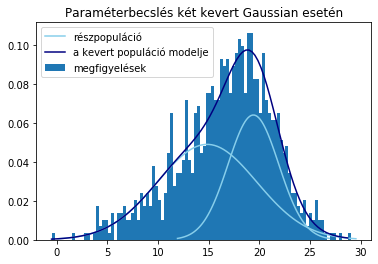

In [14]:
import matplotlib.pyplot as plt
plt.clf()
plt.title("Paraméterbecslés két kevert Gaussian esetén")

# bins
data = observation
binamount = 100
step = (max(data)-min(data))/binamount
binslabels = [ min(data)+s*step for s in range(binamount+2) ]
weights = np.ones_like(data)/float(len(data))


# a részpopulációk modellje
def drawnormal(mu, sigma, p, label=True):
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, binamount)
    statistical_model =  stats.norm.pdf( 
        x,
        mu,
        sigma
    )
    if label:
        plt.plot(x, p*statistical_model, color="skyblue", label="részpopuláció")
    else:
        plt.plot(x, p*statistical_model, color="skyblue")
    
drawnormal(models[bestidx]['mean'][0], models[bestidx]['std'][0], models[bestidx]['p'][0], label=False)
drawnormal(models[bestidx]['mean'][1], models[bestidx]['std'][1], models[bestidx]['p'][1])

# a teljes megfigyelt populáció modellje
x = np.linspace(min(observation), max(observation), binamount)
final_p = finalmodel.pdf(x)
plt.plot(x, final_p, color="navy", label="a kevert populáció modelje")

# megfigyelt adatok
plt.hist(data, density=True, bins = binslabels , weights=weights, label="megfigyelések")

# jelmagyarázat
plt.legend()

plt.show()